In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
import pickle

import seaborn as sns
from utils import timeseries_visualization, load_data, visualize_hist_and_boxplot, visualize_pca
np.random.seed(1)
random.seed(1)


ModuleNotFoundError: No module named 'utils'

In [2]:
# Load data and compute lagged features
df_lagged = load_data(lagged=True, exclude_ids=True)
# Dropping NaN values
df_lagged = df_lagged.dropna()
#df_lagged


In [3]:
# Remove from the data records with labels being 3,4 and 5

df_lagged = df_lagged[~df_lagged['label'].isin([3, 4, 5])]



In [4]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Normalize the numerical columns (excluding the 'subject_id' column)
#numerical_columns = [col for col in df_lagged.columns if col != 'subject_id' and col!='label' and col!='timestamp']
#df_lagged[numerical_columns] = scaler.fit_transform(df_lagged[numerical_columns])


numerical_columns = [col for col in df_lagged.columns if col != 'subject_id' and col!='label' and col!='timestamp']
df_lagged[numerical_columns] = scaler.fit_transform(df_lagged[numerical_columns])




In [5]:

# Assuming df is your dataframe containing the data

pca = PCA(n_components=11)
exclude_columns = ['timestamp', 'subject_id', 'label']
df_lagged_PC = df_lagged.drop(exclude_columns, axis=1)
components = pca.fit_transform(df_lagged_PC)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}


lr_values = [0.1]
exclude_columns = ['timestamp', 'subject_id', 'label']

X = components
y = df_lagged['label'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)
print(X_test.shape)

# Split the data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

(436783, 11)


In [6]:
print(X_test.shape)

(436783, 11)


In [7]:
from keras.utils import to_categorical

# Map labels to one-hot encoding
label_mapping = {1: 0, 6: 1, 7: 2, 8: 3}




y_train_one_hot= np.array([label_mapping[label] for label in y_train])
y_train_one_hot = to_categorical(y_train_one_hot, num_classes=4)  # 4 classes (0, 1, 2, 3) for one-hot encoding

y_test_one_hot= np.array([label_mapping[label] for label in y_test])
y_test_one_hot = to_categorical(y_test_one_hot, num_classes=4)  # 4 classes (0, 1, 2, 3) for one-hot encoding


y_val_one_hot = np.array([label_mapping[label] for label in y_val])
y_val_one_hot = to_categorical(y_val_one_hot, num_classes=4)  # 4 classes (0, 1, 2, 3) for one-hot encoding

val_min_hypertune = {}
train_min_hypertune = {}
config_models = []


n_epochs = 30

# Reshape the data to match the input shape of the RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)


In [11]:

# -------------------------------- FIRST MODEL --------------------------------------------------------------------------------
n_layers= 1
n_hidden_units = 64
config_model_1 = (n_layers, n_hidden_units)
config_models.append(config_model_1)

model_RNN_1 = keras.Sequential([
    keras.layers.Dense(units=64, activation='relu', input_shape=(X_train.shape[1], )),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(4, activation='softmax')  
])

# Compile the model
model_RNN_1.compile(optimizer='adam', loss='categorical_crossentropy')  

# Train the model

mcp_save = tf.keras.callbacks.ModelCheckpoint('RNN_eng1.ckpt', save_best_only=True, monitor='val_loss', mode='min')

history = model_RNN_1.fit(X_train, y_train_one_hot, epochs=n_epochs, batch_size=32, validation_data=(X_val, y_val_one_hot), callbacks=[mcp_save])

train_loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']
min_train = min(train_loss_1)
min_val = min(val_loss_1)
train_min_hypertune[config_model_1]=min_train
val_min_hypertune[config_model_1]=min_val



# -------------------------------- SECOND MODEL --------------------------------------------------------------------------------
n_layers= 2
n_hidden_units = 64
config_model_2 = (n_layers, n_hidden_units)
config_models.append(config_model_2)

model_RNN_2 = keras.Sequential([
    keras.layers.Dense(units=64, activation='relu', input_shape=(X_train.shape[1], )),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(4, activation='softmax')  
])

# Compile the model
model_RNN_2.compile(optimizer='adam', loss='categorical_crossentropy')  


# Train the model

mcp_save = tf.keras.callbacks.ModelCheckpoint('RNN_eng2.ckpt', save_best_only=True, monitor='val_loss', mode='min')

history = model_RNN_2.fit(X_train, y_train_one_hot, epochs=n_epochs, batch_size=32, validation_data=(X_val, y_val_one_hot), callbacks=[mcp_save])

train_loss_2 = history.history['loss']
val_loss_2 = history.history['val_loss']

min_train = min(train_loss_2)
min_val = min(val_loss_2)
train_min_hypertune[config_model_2]=min_train
val_min_hypertune[config_model_2]=min_val

# --------------------------------------THIRD MODEL-----------------------------------------------------------------------------
n_layers= 3
n_hidden_units = 64
config_model_3 = (n_layers, n_hidden_units)
config_models.append(config_model_3)

model_RNN_3 = keras.Sequential([
    keras.layers.Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(4, activation='softmax')  
])

# Compile the model
model_RNN_3.compile(optimizer='adam', loss='categorical_crossentropy')  

# Train the model

mcp_save = tf.keras.callbacks.ModelCheckpoint('RNN_eng3.ckpt', save_best_only=True, monitor='val_loss', mode='min')

history = model_RNN_3.fit(X_train, y_train_one_hot, epochs=n_epochs, batch_size=32, validation_data=(X_val, y_val_one_hot), callbacks=[mcp_save])

train_loss_3 = history.history['loss']
val_loss_3 = history.history['val_loss']

min_train = min(train_loss_3)
min_val = min(val_loss_3)
train_min_hypertune[config_model_3]=min_train
val_min_hypertune[config_model_3]=min_val

# --------------------------------------FOURTH MODEL-----------------------------------------------------------------------------
n_layers= 1
n_hidden_units = 128
config_model_4 = (n_layers, n_hidden_units)
config_models.append(config_model_4)

model_RNN_4 = keras.Sequential([
    keras.layers.Dense(units=128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(4, activation='softmax')  
])

# Compile the model
model_RNN_4.compile(optimizer='adam', loss='categorical_crossentropy')  

# Train the model

mcp_save = tf.keras.callbacks.ModelCheckpoint('RNN_eng4.ckpt', save_best_only=True, monitor='val_loss', mode='min')

history = model_RNN_4.fit(X_train, y_train_one_hot, epochs=n_epochs, batch_size=32, validation_data=(X_val, y_val_one_hot), callbacks=[mcp_save])

train_loss_4 = history.history['loss']
val_loss_4 = history.history['val_loss']

min_train = min(train_loss_4)
min_val = min(val_loss_4)
train_min_hypertune[config_model_4]=min_train
val_min_hypertune[config_model_4]=min_val


# --------------------------------------FIFTH MODEL-----------------------------------------------------------------------------
n_layers= 2
n_hidden_units = 128
config_model_5 = (n_layers, n_hidden_units)
config_models.append(config_model_5)

model_RNN_5 = keras.Sequential([
    keras.layers.Dense(units=128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(4, activation='softmax')  
])

# Compile the model
model_RNN_5.compile(optimizer='adam', loss='categorical_crossentropy')  

# Train the model

mcp_save = tf.keras.callbacks.ModelCheckpoint('RNN_eng5.ckpt', save_best_only=True, monitor='val_loss', mode='min')

history = model_RNN_5.fit(X_train, y_train_one_hot, epochs=n_epochs, batch_size=32, validation_data=(X_val, y_val_one_hot), callbacks=[mcp_save])

train_loss_5 = history.history['loss']
val_loss_5 = history.history['val_loss']

min_train = min(train_loss_5)
min_val = min(val_loss_5)
train_min_hypertune[config_model_5]=min_train
val_min_hypertune[config_model_5]=min_val


# --------------------------------------SIXTH MODEL-----------------------------------------------------------------------------
n_layers= 3
n_hidden_units = 128
config_model_6 = (n_layers, n_hidden_units)
config_models.append(config_model_6)

model_RNN_6 = keras.Sequential([
    keras.layers.Dense(units=128, activation='relu', input_shape=(X_train.shape[1], )),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(4, activation='softmax')  
])

# Compile the model
model_RNN_6.compile(optimizer='adam', loss='categorical_crossentropy')  

# Reshape the data to match the input shape of the RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# Train the model

mcp_save = tf.keras.callbacks.ModelCheckpoint('RNN_eng6.ckpt', save_best_only=True, monitor='val_loss', mode='min')

history = model_RNN_6.fit(X_train, y_train_one_hot, epochs=n_epochs, batch_size=32, validation_data=(X_val, y_val_one_hot), callbacks=[mcp_save])

train_loss_6 = history.history['loss']
val_loss_6 = history.history['val_loss']

min_train = min(train_loss_6)
min_val = min(val_loss_6)
train_min_hypertune[config_model_6]=min_train
val_min_hypertune[config_model_6]=min_val


# --------------------------------------SEVENTH MODEL-----------------------------------------------------------------------------
n_layers= 1
n_hidden_units = 32
config_model_7 = (n_layers, n_hidden_units)
config_models.append(config_model_7)

model_RNN_7 = keras.Sequential([
    keras.layers.Dense(units=32, activation='relu', input_shape=(X_train.shape[1], )),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(4, activation='softmax')  
])

# Compile the model
model_RNN_7.compile(optimizer='adam', loss='categorical_crossentropy')  

# Train the model
mcp_save = tf.keras.callbacks.ModelCheckpoint('RNN_eng7.ckpt', save_best_only=True, monitor='val_loss', mode='min')
history = model_RNN_7.fit(X_train, y_train_one_hot, epochs=n_epochs, batch_size=32, validation_data=(X_val, y_val_one_hot), callbacks=[mcp_save])

train_loss_7 = history.history['loss']
val_loss_7 = history.history['val_loss']

min_train = min(train_loss_7)
min_val = min(val_loss_7)
train_min_hypertune[config_model_7]=min_train
val_min_hypertune[config_model_7]=min_val




# --------------------------------------EIGTH MODEL-----------------------------------------------------------------------------
n_layers= 2
n_hidden_units = 32

config_model_8 = (n_layers, n_hidden_units)
config_models.append(config_model_8)

model_RNN_8 = keras.Sequential([
    keras.layers.Dense(units=32, activation='relu', input_shape=(X_train.shape[1], )),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(4, activation='softmax')  
])

# Compile the model
model_RNN_8.compile(optimizer='adam', loss='categorical_crossentropy')  

# Train the model

mcp_save = tf.keras.callbacks.ModelCheckpoint('RNN_eng8.ckpt', save_best_only=True, monitor='val_loss', mode='min')

history = model_RNN_8.fit(X_train, y_train_one_hot, epochs=n_epochs, batch_size=32, validation_data=(X_val, y_val_one_hot), callbacks=[mcp_save])

train_loss_8 = history.history['loss']
val_loss_8 = history.history['val_loss']
min_train = min(train_loss_8)
min_val = min(val_loss_8)
train_min_hypertune[config_model_8]=min_train
val_min_hypertune[config_model_8]=min_val

# --------------------------------------NINTH MODEL-----------------------------------------------------------------------------
n_layers= 3
n_hidden_units = 32

config_model_9 = (n_layers, n_hidden_units)
config_models.append(config_model_9)

model_RNN_9 = keras.Sequential([
    keras.layers.Dense(units=32, activation='relu', input_shape=(X_train.shape[1], )),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(4, activation='softmax')  
])

# Compile the model
model_RNN_9.compile(optimizer='adam', loss='categorical_crossentropy')  

# Train the model

mcp_save = tf.keras.callbacks.ModelCheckpoint('RNN_eng9.ckpt', save_best_only=True, monitor='val_loss', mode='min')
history = model_RNN_9.fit(X_train, y_train_one_hot, epochs=n_epochs, batch_size=32, validation_data=(X_val, y_val_one_hot), callbacks=[mcp_save])

train_loss_9 = history.history['loss']
val_loss_9 = history.history['val_loss']

min_train = min(train_loss_9)
min_val = min(val_loss_9)
train_min_hypertune[config_model_9]=min_train
val_min_hypertune[config_model_9]=min_val

Epoch 1/30
43641/43679 [============================>.] - ETA: 0s - loss: 0.0955INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


43679/43679 [==============================] - 66s 1ms/step - loss: 0.0955 - val_loss: 0.0782
Epoch 2/30
43643/43679 [============================>.] - ETA: 0s - loss: 0.0751INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


43679/43679 [==============================] - 65s 1ms/step - loss: 0.0751 - val_loss: 0.0725
Epoch 3/30
43677/43679 [============================>.] - ETA: 0s - loss: 0.0710INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


43679/43679 [==============================] - 65s 1ms/step - loss: 0.0710 - val_loss: 0.0703
Epoch 4/30
43677/43679 [============================>.] - ETA: 0s - loss: 0.0690INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


43679/43679 [==============================] - 65s 1ms/step - loss: 0.0690 - val_loss: 0.0694
Epoch 5/30
43671/43679 [============================>.] - ETA: 0s - loss: 0.0677INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


43679/43679 [==============================] - 66s 2ms/step - loss: 0.0676 - val_loss: 0.0693
Epoch 6/30
43679/43679 [==============================] - 65s 1ms/step - loss: 0.0667 - val_loss: 0.0694
Epoch 7/30
43648/43679 [============================>.] - ETA: 0s - loss: 0.0658INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


43679/43679 [==============================] - 65s 1ms/step - loss: 0.0658 - val_loss: 0.0678
Epoch 8/30
43679/43679 [==============================] - 64s 1ms/step - loss: 0.0651 - val_loss: 0.0682
Epoch 9/30
43679/43679 [==============================] - 64s 1ms/step - loss: 0.0646 - val_loss: 0.0682
Epoch 10/30
43667/43679 [============================>.] - ETA: 0s - loss: 0.0641INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


43679/43679 [==============================] - 65s 1ms/step - loss: 0.0641 - val_loss: 0.0661
Epoch 11/30
43653/43679 [============================>.] - ETA: 0s - loss: 0.0637INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


43679/43679 [==============================] - 65s 1ms/step - loss: 0.0637 - val_loss: 0.0653
Epoch 12/30
43679/43679 [==============================] - 65s 1ms/step - loss: 0.0634 - val_loss: 0.0662
Epoch 13/30
43679/43679 [==============================] - 64s 1ms/step - loss: 0.0630 - val_loss: 0.0662
Epoch 14/30
43667/43679 [============================>.] - ETA: 0s - loss: 0.0629INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


43679/43679 [==============================] - 68s 2ms/step - loss: 0.0629 - val_loss: 0.0650
Epoch 15/30
43662/43679 [============================>.] - ETA: 0s - loss: 0.0625INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


43679/43679 [==============================] - 67s 2ms/step - loss: 0.0625 - val_loss: 0.0639
Epoch 16/30
43679/43679 [==============================] - 65s 1ms/step - loss: 0.0622 - val_loss: 0.0660
Epoch 17/30
43679/43679 [==============================] - 64s 1ms/step - loss: 0.0622 - val_loss: 0.0644
Epoch 18/30
43679/43679 [==============================] - 64s 1ms/step - loss: 0.0619 - val_loss: 0.0665
Epoch 19/30
43646/43679 [============================>.] - ETA: 0s - loss: 0.0617INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


43679/43679 [==============================] - 64s 1ms/step - loss: 0.0617 - val_loss: 0.0638
Epoch 20/30
43679/43679 [==============================] - 64s 1ms/step - loss: 0.0616 - val_loss: 0.0645
Epoch 21/30
43679/43679 [==============================] - 64s 1ms/step - loss: 0.0614 - val_loss: 0.0648
Epoch 22/30
43679/43679 [==============================] - 64s 1ms/step - loss: 0.0612 - val_loss: 0.0654
Epoch 23/30
43679/43679 [==============================] - 64s 1ms/step - loss: 0.0613 - val_loss: 0.0644
Epoch 24/30
43679/43679 [==============================] - 64s 1ms/step - loss: 0.0611 - val_loss: 0.0651
Epoch 25/30
43650/43679 [============================>.] - ETA: 0s - loss: 0.0610INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng1.ckpt\assets


43679/43679 [==============================] - 65s 1ms/step - loss: 0.0610 - val_loss: 0.0630
Epoch 26/30
43679/43679 [==============================] - 64s 1ms/step - loss: 0.0608 - val_loss: 0.0635
Epoch 27/30
43679/43679 [==============================] - 65s 1ms/step - loss: 0.0608 - val_loss: 0.0639
Epoch 28/30
43679/43679 [==============================] - 64s 1ms/step - loss: 0.0608 - val_loss: 0.0642
Epoch 29/30
43679/43679 [==============================] - 64s 1ms/step - loss: 0.0605 - val_loss: 0.0637
Epoch 30/30
43679/43679 [==============================] - 64s 1ms/step - loss: 0.0605 - val_loss: 0.0652
Epoch 1/30
43666/43679 [============================>.] - ETA: 0s - loss: 0.0910INFO:tensorflow:Assets written to: RNN_eng2.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng2.ckpt\assets


43679/43679 [==============================] - 69s 2ms/step - loss: 0.0910 - val_loss: 0.0874
Epoch 2/30
43674/43679 [============================>.] - ETA: 0s - loss: 0.0726INFO:tensorflow:Assets written to: RNN_eng2.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng2.ckpt\assets


43679/43679 [==============================] - 69s 2ms/step - loss: 0.0726 - val_loss: 0.0708
Epoch 3/30
43652/43679 [============================>.] - ETA: 0s - loss: 0.0689INFO:tensorflow:Assets written to: RNN_eng2.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng2.ckpt\assets


43679/43679 [==============================] - 71s 2ms/step - loss: 0.0689 - val_loss: 0.0698
Epoch 4/30
43658/43679 [============================>.] - ETA: 0s - loss: 0.0670INFO:tensorflow:Assets written to: RNN_eng2.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng2.ckpt\assets


43679/43679 [==============================] - 65s 1ms/step - loss: 0.0670 - val_loss: 0.0676
Epoch 5/30
43669/43679 [============================>.] - ETA: 0s - loss: 0.0655INFO:tensorflow:Assets written to: RNN_eng2.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng2.ckpt\assets


43679/43679 [==============================] - 65s 1ms/step - loss: 0.0655 - val_loss: 0.0672
Epoch 6/30
43660/43679 [============================>.] - ETA: 0s - loss: 0.0646INFO:tensorflow:Assets written to: RNN_eng2.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng2.ckpt\assets


43679/43679 [==============================] - 65s 1ms/step - loss: 0.0646 - val_loss: 0.0654
Epoch 7/30
43679/43679 [==============================] - 65s 1ms/step - loss: 0.0638 - val_loss: 0.0656
Epoch 8/30
43679/43679 [==============================] - 64s 1ms/step - loss: 0.0633 - val_loss: 0.0655
Epoch 9/30
43679/43679 [==============================] - 64s 1ms/step - loss: 0.0629 - val_loss: 0.0674
Epoch 10/30
43653/43679 [============================>.] - ETA: 0s - loss: 0.0626INFO:tensorflow:Assets written to: RNN_eng2.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng2.ckpt\assets


43679/43679 [==============================] - 65s 1ms/step - loss: 0.0626 - val_loss: 0.0652
Epoch 11/30
43677/43679 [============================>.] - ETA: 0s - loss: 0.0622INFO:tensorflow:Assets written to: RNN_eng2.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng2.ckpt\assets


43679/43679 [==============================] - 67s 2ms/step - loss: 0.0622 - val_loss: 0.0644
Epoch 12/30
43679/43679 [==============================] - 66s 2ms/step - loss: 0.0622 - val_loss: 0.0652
Epoch 13/30
43679/43679 [==============================] - 64s 1ms/step - loss: 0.0620 - val_loss: 0.0655
Epoch 14/30
43679/43679 [==============================] - 64s 1ms/step - loss: 0.0619 - val_loss: 0.0648
Epoch 15/30
43679/43679 [==============================] - 65s 1ms/step - loss: 0.0620 - val_loss: 0.0649
Epoch 16/30
43677/43679 [============================>.] - ETA: 0s - loss: 0.0619INFO:tensorflow:Assets written to: RNN_eng2.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng2.ckpt\assets


43679/43679 [==============================] - 65s 1ms/step - loss: 0.0619 - val_loss: 0.0639
Epoch 17/30
43679/43679 [==============================] - 67s 2ms/step - loss: 0.0615 - val_loss: 0.0650
Epoch 18/30
43679/43679 [==============================] - 68s 2ms/step - loss: 0.0616 - val_loss: 0.0667
Epoch 19/30
43679/43679 [==============================] - 69s 2ms/step - loss: 0.0617 - val_loss: 0.0658
Epoch 20/30
43679/43679 [==============================] - 69s 2ms/step - loss: 0.0616 - val_loss: 0.0666
Epoch 21/30
43679/43679 [==============================] - 69s 2ms/step - loss: 0.0616 - val_loss: 0.0659
Epoch 22/30
43679/43679 [==============================] - 69s 2ms/step - loss: 0.0624 - val_loss: 0.0640
Epoch 23/30
43679/43679 [==============================] - 69s 2ms/step - loss: 0.0619 - val_loss: 0.0653
Epoch 24/30
43679/43679 [==============================] - 69s 2ms/step - loss: 0.0617 - val_loss: 0.0691
Epoch 25/30
43679/43679 [==============================] -

INFO:tensorflow:Assets written to: RNN_eng3.ckpt\assets


43679/43679 [==============================] - 74s 2ms/step - loss: 0.0902 - val_loss: 0.0751
Epoch 2/30
43679/43679 [==============================] - ETA: 0s - loss: 0.0733INFO:tensorflow:Assets written to: RNN_eng3.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng3.ckpt\assets


43679/43679 [==============================] - 73s 2ms/step - loss: 0.0733 - val_loss: 0.0725
Epoch 3/30
43648/43679 [============================>.] - ETA: 0s - loss: 0.0700INFO:tensorflow:Assets written to: RNN_eng3.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng3.ckpt\assets


43679/43679 [==============================] - 73s 2ms/step - loss: 0.0700 - val_loss: 0.0711
Epoch 4/30
43679/43679 [==============================] - ETA: 0s - loss: 0.0685INFO:tensorflow:Assets written to: RNN_eng3.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng3.ckpt\assets


43679/43679 [==============================] - 73s 2ms/step - loss: 0.0685 - val_loss: 0.0696
Epoch 5/30
43646/43679 [============================>.] - ETA: 0s - loss: 0.0672INFO:tensorflow:Assets written to: RNN_eng3.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng3.ckpt\assets


43679/43679 [==============================] - 73s 2ms/step - loss: 0.0672 - val_loss: 0.0672
Epoch 6/30
43679/43679 [==============================] - 72s 2ms/step - loss: 0.0666 - val_loss: 0.0697
Epoch 7/30
43677/43679 [============================>.] - ETA: 0s - loss: 0.0658INFO:tensorflow:Assets written to: RNN_eng3.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng3.ckpt\assets


43679/43679 [==============================] - 72s 2ms/step - loss: 0.0658 - val_loss: 0.0668
Epoch 8/30
43669/43679 [============================>.] - ETA: 0s - loss: 0.0654INFO:tensorflow:Assets written to: RNN_eng3.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng3.ckpt\assets


43679/43679 [==============================] - 73s 2ms/step - loss: 0.0654 - val_loss: 0.0658
Epoch 9/30
43679/43679 [==============================] - 72s 2ms/step - loss: 0.0647 - val_loss: 0.0669
Epoch 10/30
43679/43679 [==============================] - 72s 2ms/step - loss: 0.0648 - val_loss: 0.0673
Epoch 11/30
43679/43679 [==============================] - 72s 2ms/step - loss: 0.0644 - val_loss: 0.0666
Epoch 12/30
43679/43679 [==============================] - 73s 2ms/step - loss: 0.0649 - val_loss: 0.0711
Epoch 13/30
43668/43679 [============================>.] - ETA: 0s - loss: 0.0643INFO:tensorflow:Assets written to: RNN_eng3.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng3.ckpt\assets


43679/43679 [==============================] - 73s 2ms/step - loss: 0.0643 - val_loss: 0.0649
Epoch 14/30
43679/43679 [==============================] - 72s 2ms/step - loss: 0.0641 - val_loss: 0.0684
Epoch 15/30
43679/43679 [==============================] - 72s 2ms/step - loss: 0.0649 - val_loss: 0.0709
Epoch 16/30
43679/43679 [==============================] - 72s 2ms/step - loss: 0.0653 - val_loss: 0.0679
Epoch 17/30
43679/43679 [==============================] - 72s 2ms/step - loss: 0.0644 - val_loss: 0.0682
Epoch 18/30
43665/43679 [============================>.] - ETA: 0s - loss: 0.0655INFO:tensorflow:Assets written to: RNN_eng3.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng3.ckpt\assets


43679/43679 [==============================] - 73s 2ms/step - loss: 0.0655 - val_loss: 0.0642
Epoch 19/30
43679/43679 [==============================] - 72s 2ms/step - loss: 0.0641 - val_loss: 0.0663
Epoch 20/30
43679/43679 [==============================] - 73s 2ms/step - loss: 0.0652 - val_loss: 0.0694
Epoch 21/30
43679/43679 [==============================] - 73s 2ms/step - loss: 0.0665 - val_loss: 0.0755
Epoch 22/30
43679/43679 [==============================] - 73s 2ms/step - loss: 0.0660 - val_loss: 0.0782
Epoch 23/30
43679/43679 [==============================] - 74s 2ms/step - loss: 0.0688 - val_loss: 0.0754
Epoch 24/30
43679/43679 [==============================] - 71s 2ms/step - loss: 0.0656 - val_loss: 0.0715
Epoch 25/30
43679/43679 [==============================] - 72s 2ms/step - loss: 0.0682 - val_loss: 0.0687
Epoch 26/30
43679/43679 [==============================] - 74s 2ms/step - loss: 0.0681 - val_loss: 0.0731
Epoch 27/30
43679/43679 [==============================] -

INFO:tensorflow:Assets written to: RNN_eng4.ckpt\assets


43679/43679 [==============================] - 70s 2ms/step - loss: 0.0891 - val_loss: 0.0754
Epoch 2/30
43677/43679 [============================>.] - ETA: 0s - loss: 0.0713INFO:tensorflow:Assets written to: RNN_eng4.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng4.ckpt\assets


43679/43679 [==============================] - 67s 2ms/step - loss: 0.0713 - val_loss: 0.0704
Epoch 3/30
43673/43679 [============================>.] - ETA: 0s - loss: 0.0679INFO:tensorflow:Assets written to: RNN_eng4.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng4.ckpt\assets


43679/43679 [==============================] - 67s 2ms/step - loss: 0.0679 - val_loss: 0.0674
Epoch 4/30
43679/43679 [==============================] - 66s 2ms/step - loss: 0.0657 - val_loss: 0.0683
Epoch 5/30
43672/43679 [============================>.] - ETA: 0s - loss: 0.0644INFO:tensorflow:Assets written to: RNN_eng4.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng4.ckpt\assets


43679/43679 [==============================] - 67s 2ms/step - loss: 0.0644 - val_loss: 0.0670
Epoch 6/30
43679/43679 [==============================] - 66s 2ms/step - loss: 0.0635 - val_loss: 0.0679
Epoch 7/30
43658/43679 [============================>.] - ETA: 0s - loss: 0.0627INFO:tensorflow:Assets written to: RNN_eng4.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng4.ckpt\assets


43679/43679 [==============================] - 67s 2ms/step - loss: 0.0627 - val_loss: 0.0645
Epoch 8/30
43679/43679 [==============================] - 67s 2ms/step - loss: 0.0622 - val_loss: 0.0665
Epoch 9/30
43647/43679 [============================>.] - ETA: 0s - loss: 0.0617INFO:tensorflow:Assets written to: RNN_eng4.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng4.ckpt\assets


43679/43679 [==============================] - 67s 2ms/step - loss: 0.0617 - val_loss: 0.0643
Epoch 10/30
43646/43679 [============================>.] - ETA: 0s - loss: 0.0613INFO:tensorflow:Assets written to: RNN_eng4.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng4.ckpt\assets


43679/43679 [==============================] - 67s 2ms/step - loss: 0.0613 - val_loss: 0.0632
Epoch 11/30
43679/43679 [==============================] - 67s 2ms/step - loss: 0.0608 - val_loss: 0.0649
Epoch 12/30
43672/43679 [============================>.] - ETA: 0s - loss: 0.0609INFO:tensorflow:Assets written to: RNN_eng4.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng4.ckpt\assets


43679/43679 [==============================] - 68s 2ms/step - loss: 0.0609 - val_loss: 0.0629
Epoch 13/30
43679/43679 [==============================] - 70s 2ms/step - loss: 0.0605 - val_loss: 0.0638
Epoch 14/30
43679/43679 [==============================] - 71s 2ms/step - loss: 0.0602 - val_loss: 0.0633
Epoch 15/30
43679/43679 [==============================] - 71s 2ms/step - loss: 0.0600 - val_loss: 0.0651
Epoch 16/30
43679/43679 [==============================] - 70s 2ms/step - loss: 0.0597 - val_loss: 0.0639
Epoch 17/30
43672/43679 [============================>.] - ETA: 0s - loss: 0.0598INFO:tensorflow:Assets written to: RNN_eng4.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng4.ckpt\assets


43679/43679 [==============================] - 74s 2ms/step - loss: 0.0598 - val_loss: 0.0623
Epoch 18/30
43679/43679 [==============================] - 71s 2ms/step - loss: 0.0594 - val_loss: 0.0646
Epoch 19/30
43679/43679 [==============================] - 71s 2ms/step - loss: 0.0597 - val_loss: 0.0645
Epoch 20/30
43676/43679 [============================>.] - ETA: 0s - loss: 0.0592INFO:tensorflow:Assets written to: RNN_eng4.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng4.ckpt\assets


43679/43679 [==============================] - 65s 1ms/step - loss: 0.0592 - val_loss: 0.0620
Epoch 21/30
43679/43679 [==============================] - 68s 2ms/step - loss: 0.0595 - val_loss: 0.0625
Epoch 22/30
43679/43679 [==============================] - 72s 2ms/step - loss: 0.0589 - val_loss: 0.0665
Epoch 23/30
43679/43679 [==============================] - 72s 2ms/step - loss: 0.0592 - val_loss: 0.0634
Epoch 24/30
43679/43679 [==============================] - 67s 2ms/step - loss: 0.0591 - val_loss: 0.0636
Epoch 25/30
43679/43679 [==============================] - 67s 2ms/step - loss: 0.0586 - val_loss: 0.0633
Epoch 26/30
43679/43679 [==============================] - 67s 2ms/step - loss: 0.0586 - val_loss: 0.0649
Epoch 27/30
43679/43679 [==============================] - 67s 2ms/step - loss: 0.0586 - val_loss: 0.0627
Epoch 28/30
43679/43679 [==============================] - 67s 2ms/step - loss: 0.0581 - val_loss: 0.0623
Epoch 29/30
43679/43679 [==============================] -

INFO:tensorflow:Assets written to: RNN_eng5.ckpt\assets


43679/43679 [==============================] - 76s 2ms/step - loss: 0.0865 - val_loss: 0.0743
Epoch 2/30
43673/43679 [============================>.] - ETA: 0s - loss: 0.0700INFO:tensorflow:Assets written to: RNN_eng5.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng5.ckpt\assets


43679/43679 [==============================] - 74s 2ms/step - loss: 0.0700 - val_loss: 0.0672
Epoch 3/30
43679/43679 [==============================] - 73s 2ms/step - loss: 0.0670 - val_loss: 0.0675
Epoch 4/30
43649/43679 [============================>.] - ETA: 0s - loss: 0.0656INFO:tensorflow:Assets written to: RNN_eng5.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng5.ckpt\assets


43679/43679 [==============================] - 74s 2ms/step - loss: 0.0656 - val_loss: 0.0667
Epoch 5/30
43660/43679 [============================>.] - ETA: 0s - loss: 0.0644INFO:tensorflow:Assets written to: RNN_eng5.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng5.ckpt\assets


43679/43679 [==============================] - 74s 2ms/step - loss: 0.0644 - val_loss: 0.0646
Epoch 6/30
43679/43679 [==============================] - 73s 2ms/step - loss: 0.0637 - val_loss: 0.0663
Epoch 7/30
43679/43679 [==============================] - 73s 2ms/step - loss: 0.0634 - val_loss: 0.0735
Epoch 8/30
43679/43679 [==============================] - 74s 2ms/step - loss: 0.0643 - val_loss: 0.0659
Epoch 9/30
43679/43679 [==============================] - 74s 2ms/step - loss: 0.0631 - val_loss: 0.0648
Epoch 10/30
43679/43679 [==============================] - 75s 2ms/step - loss: 0.0655 - val_loss: 0.0657
Epoch 11/30
43679/43679 [==============================] - 74s 2ms/step - loss: 0.0620 - val_loss: 0.0693
Epoch 12/30
43679/43679 [==============================] - 73s 2ms/step - loss: 0.0628 - val_loss: 0.0646
Epoch 13/30
43662/43679 [============================>.] - ETA: 0s - loss: 0.0616INFO:tensorflow:Assets written to: RNN_eng5.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng5.ckpt\assets


43679/43679 [==============================] - 74s 2ms/step - loss: 0.0616 - val_loss: 0.0639
Epoch 14/30
43679/43679 [==============================] - 74s 2ms/step - loss: 0.0619 - val_loss: 0.0757
Epoch 15/30
43679/43679 [==============================] - 74s 2ms/step - loss: 0.0630 - val_loss: 0.0776
Epoch 16/30
43679/43679 [==============================] - 74s 2ms/step - loss: 0.0663 - val_loss: 0.0867
Epoch 17/30
43679/43679 [==============================] - 73s 2ms/step - loss: 0.0651 - val_loss: 0.0774
Epoch 18/30
43679/43679 [==============================] - 74s 2ms/step - loss: 0.0819 - val_loss: 0.0868
Epoch 19/30
43679/43679 [==============================] - 74s 2ms/step - loss: 0.0625 - val_loss: 0.1018
Epoch 20/30
43679/43679 [==============================] - 73s 2ms/step - loss: 0.0644 - val_loss: 0.0966
Epoch 21/30
43679/43679 [==============================] - 74s 2ms/step - loss: 0.0648 - val_loss: 0.1640
Epoch 22/30
43679/43679 [==============================] -

INFO:tensorflow:Assets written to: RNN_eng6.ckpt\assets


43679/43679 [==============================] - 80s 2ms/step - loss: 0.0875 - val_loss: 0.0772
Epoch 2/30
43644/43679 [============================>.] - ETA: 0s - loss: 0.0713INFO:tensorflow:Assets written to: RNN_eng6.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng6.ckpt\assets


43679/43679 [==============================] - 79s 2ms/step - loss: 0.0713 - val_loss: 0.0689
Epoch 3/30
43679/43679 [==============================] - 78s 2ms/step - loss: 0.0684 - val_loss: 0.0715
Epoch 4/30
43678/43679 [============================>.] - ETA: 0s - loss: 0.0667INFO:tensorflow:Assets written to: RNN_eng6.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng6.ckpt\assets


43679/43679 [==============================] - 79s 2ms/step - loss: 0.0667 - val_loss: 0.0680
Epoch 5/30
43646/43679 [============================>.] - ETA: 0s - loss: 0.0664INFO:tensorflow:Assets written to: RNN_eng6.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng6.ckpt\assets


43679/43679 [==============================] - 79s 2ms/step - loss: 0.0664 - val_loss: 0.0656
Epoch 6/30
43679/43679 [==============================] - 79s 2ms/step - loss: 0.0668 - val_loss: 0.0661
Epoch 7/30
43679/43679 [==============================] - 79s 2ms/step - loss: 0.0652 - val_loss: 0.0680
Epoch 8/30
43679/43679 [==============================] - 78s 2ms/step - loss: 0.0644 - val_loss: 0.0681
Epoch 9/30
43679/43679 [==============================] - 78s 2ms/step - loss: 0.0652 - val_loss: 0.0662
Epoch 10/30
43679/43679 [==============================] - 78s 2ms/step - loss: 0.0646 - val_loss: 0.0880
Epoch 11/30
43679/43679 [==============================] - 78s 2ms/step - loss: 0.0666 - val_loss: 0.0664
Epoch 12/30
43679/43679 [==============================] - 78s 2ms/step - loss: 0.0653 - val_loss: 0.0697
Epoch 13/30
43679/43679 [==============================] - 78s 2ms/step - loss: 0.0657 - val_loss: 0.0936
Epoch 14/30
43679/43679 [==============================] - 79s

INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


43679/43679 [==============================] - 66s 1ms/step - loss: 0.1056 - val_loss: 0.0885
Epoch 2/30
43656/43679 [============================>.] - ETA: 0s - loss: 0.0819INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


43679/43679 [==============================] - 63s 1ms/step - loss: 0.0819 - val_loss: 0.0792
Epoch 3/30
43651/43679 [============================>.] - ETA: 0s - loss: 0.0778INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


43679/43679 [==============================] - 63s 1ms/step - loss: 0.0778 - val_loss: 0.0790
Epoch 4/30
43657/43679 [============================>.] - ETA: 0s - loss: 0.0756INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


43679/43679 [==============================] - 64s 1ms/step - loss: 0.0756 - val_loss: 0.0756
Epoch 5/30
43679/43679 [==============================] - 63s 1ms/step - loss: 0.0740 - val_loss: 0.0761
Epoch 6/30
43671/43679 [============================>.] - ETA: 0s - loss: 0.0730INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


43679/43679 [==============================] - 64s 1ms/step - loss: 0.0730 - val_loss: 0.0755
Epoch 7/30
43670/43679 [============================>.] - ETA: 0s - loss: 0.0722INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


43679/43679 [==============================] - 63s 1ms/step - loss: 0.0722 - val_loss: 0.0728
Epoch 8/30
43679/43679 [==============================] - 63s 1ms/step - loss: 0.0715 - val_loss: 0.0785
Epoch 9/30
43649/43679 [============================>.] - ETA: 0s - loss: 0.0709INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


43679/43679 [==============================] - 64s 1ms/step - loss: 0.0709 - val_loss: 0.0722
Epoch 10/30
43679/43679 [==============================] - 63s 1ms/step - loss: 0.0705 - val_loss: 0.0726
Epoch 11/30
43679/43679 [==============================] - 63s 1ms/step - loss: 0.0700 - val_loss: 0.0739
Epoch 12/30
43640/43679 [============================>.] - ETA: 0s - loss: 0.0698INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


43679/43679 [==============================] - 64s 1ms/step - loss: 0.0698 - val_loss: 0.0718
Epoch 13/30
43654/43679 [============================>.] - ETA: 0s - loss: 0.0694INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


43679/43679 [==============================] - 64s 1ms/step - loss: 0.0694 - val_loss: 0.0710
Epoch 14/30
43679/43679 [==============================] - 63s 1ms/step - loss: 0.0691 - val_loss: 0.0719
Epoch 15/30
43679/43679 [==============================] - 63s 1ms/step - loss: 0.0689 - val_loss: 0.0719
Epoch 16/30
43679/43679 [==============================] - 63s 1ms/step - loss: 0.0685 - val_loss: 0.0724
Epoch 17/30
43644/43679 [============================>.] - ETA: 0s - loss: 0.0684INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


43679/43679 [==============================] - 64s 1ms/step - loss: 0.0684 - val_loss: 0.0705
Epoch 18/30
43657/43679 [============================>.] - ETA: 0s - loss: 0.0682INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


43679/43679 [==============================] - 64s 1ms/step - loss: 0.0682 - val_loss: 0.0699
Epoch 19/30
43679/43679 [==============================] - 63s 1ms/step - loss: 0.0680 - val_loss: 0.0703
Epoch 20/30
43679/43679 [==============================] - ETA: 0s - loss: 0.0679INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


43679/43679 [==============================] - 64s 1ms/step - loss: 0.0679 - val_loss: 0.0698
Epoch 21/30
43679/43679 [==============================] - 63s 1ms/step - loss: 0.0678 - val_loss: 0.0699
Epoch 22/30
43671/43679 [============================>.] - ETA: 0s - loss: 0.0676INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


43679/43679 [==============================] - 64s 1ms/step - loss: 0.0676 - val_loss: 0.0696
Epoch 23/30
43671/43679 [============================>.] - ETA: 0s - loss: 0.0677INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


43679/43679 [==============================] - 64s 1ms/step - loss: 0.0677 - val_loss: 0.0689
Epoch 24/30
43679/43679 [==============================] - 63s 1ms/step - loss: 0.0676 - val_loss: 0.0693
Epoch 25/30
43656/43679 [============================>.] - ETA: 0s - loss: 0.0675INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng7.ckpt\assets


43679/43679 [==============================] - 64s 1ms/step - loss: 0.0675 - val_loss: 0.0687
Epoch 26/30
43679/43679 [==============================] - 64s 1ms/step - loss: 0.0675 - val_loss: 0.0704
Epoch 27/30
43679/43679 [==============================] - 63s 1ms/step - loss: 0.0674 - val_loss: 0.0688
Epoch 28/30
43679/43679 [==============================] - 63s 1ms/step - loss: 0.0673 - val_loss: 0.0687
Epoch 29/30
43679/43679 [==============================] - 63s 1ms/step - loss: 0.0674 - val_loss: 0.0697
Epoch 30/30
43679/43679 [==============================] - 63s 1ms/step - loss: 0.0673 - val_loss: 0.0689
Epoch 1/30
43647/43679 [============================>.] - ETA: 0s - loss: 0.0993INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


43679/43679 [==============================] - 67s 2ms/step - loss: 0.0993 - val_loss: 0.0802
Epoch 2/30
43675/43679 [============================>.] - ETA: 0s - loss: 0.0772INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


43679/43679 [==============================] - 67s 2ms/step - loss: 0.0772 - val_loss: 0.0740
Epoch 3/30
43646/43679 [============================>.] - ETA: 0s - loss: 0.0731INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


43679/43679 [==============================] - 67s 2ms/step - loss: 0.0731 - val_loss: 0.0732
Epoch 4/30
43655/43679 [============================>.] - ETA: 0s - loss: 0.0707INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


43679/43679 [==============================] - 68s 2ms/step - loss: 0.0707 - val_loss: 0.0715
Epoch 5/30
43679/43679 [==============================] - 66s 2ms/step - loss: 0.0695 - val_loss: 0.0749
Epoch 6/30
43679/43679 [==============================] - 66s 2ms/step - loss: 0.0684 - val_loss: 0.0716
Epoch 7/30
43658/43679 [============================>.] - ETA: 0s - loss: 0.0677INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


43679/43679 [==============================] - 67s 2ms/step - loss: 0.0677 - val_loss: 0.0693
Epoch 8/30
43657/43679 [============================>.] - ETA: 0s - loss: 0.0672INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


43679/43679 [==============================] - 67s 2ms/step - loss: 0.0672 - val_loss: 0.0690
Epoch 9/30
43679/43679 [==============================] - 66s 2ms/step - loss: 0.0668 - val_loss: 0.0695
Epoch 10/30
43648/43679 [============================>.] - ETA: 0s - loss: 0.0663INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


43679/43679 [==============================] - 67s 2ms/step - loss: 0.0663 - val_loss: 0.0671
Epoch 11/30
43677/43679 [============================>.] - ETA: 0s - loss: 0.0661INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


43679/43679 [==============================] - 67s 2ms/step - loss: 0.0661 - val_loss: 0.0666
Epoch 12/30
43679/43679 [==============================] - 66s 2ms/step - loss: 0.0657 - val_loss: 0.0676
Epoch 13/30
43654/43679 [============================>.] - ETA: 0s - loss: 0.0656INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


43679/43679 [==============================] - 66s 2ms/step - loss: 0.0656 - val_loss: 0.0666
Epoch 14/30
43679/43679 [==============================] - 66s 2ms/step - loss: 0.0651 - val_loss: 0.0684
Epoch 15/30
43679/43679 [==============================] - 66s 2ms/step - loss: 0.0650 - val_loss: 0.0674
Epoch 16/30
43679/43679 [==============================] - 66s 2ms/step - loss: 0.0650 - val_loss: 0.0674
Epoch 17/30
43679/43679 [==============================] - 66s 2ms/step - loss: 0.0648 - val_loss: 0.0681
Epoch 18/30
43658/43679 [============================>.] - ETA: 0s - loss: 0.0645INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


43679/43679 [==============================] - 67s 2ms/step - loss: 0.0645 - val_loss: 0.0664
Epoch 19/30
43679/43679 [==============================] - 66s 2ms/step - loss: 0.0644 - val_loss: 0.0665
Epoch 20/30
43679/43679 [==============================] - 66s 2ms/step - loss: 0.0645 - val_loss: 0.0666
Epoch 21/30
43679/43679 [==============================] - 66s 2ms/step - loss: 0.0643 - val_loss: 0.0675
Epoch 22/30
43670/43679 [============================>.] - ETA: 0s - loss: 0.0642INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


43679/43679 [==============================] - 68s 2ms/step - loss: 0.0642 - val_loss: 0.0659
Epoch 23/30
43679/43679 [==============================] - 66s 2ms/step - loss: 0.0639 - val_loss: 0.0669
Epoch 24/30
43666/43679 [============================>.] - ETA: 0s - loss: 0.0639INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng8.ckpt\assets


43679/43679 [==============================] - 67s 2ms/step - loss: 0.0639 - val_loss: 0.0656
Epoch 25/30
43679/43679 [==============================] - 66s 2ms/step - loss: 0.0637 - val_loss: 0.0657
Epoch 26/30
43679/43679 [==============================] - 67s 2ms/step - loss: 0.0638 - val_loss: 0.0672
Epoch 27/30
43679/43679 [==============================] - 66s 2ms/step - loss: 0.0637 - val_loss: 0.0659
Epoch 28/30
43679/43679 [==============================] - 67s 2ms/step - loss: 0.0637 - val_loss: 0.0666
Epoch 29/30
43679/43679 [==============================] - 67s 2ms/step - loss: 0.0638 - val_loss: 0.0658
Epoch 30/30
43679/43679 [==============================] - 67s 2ms/step - loss: 0.0638 - val_loss: 0.0662
Epoch 1/30
43639/43679 [============================>.] - ETA: 0s - loss: 0.0938INFO:tensorflow:Assets written to: RNN_eng9.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng9.ckpt\assets


43679/43679 [==============================] - 70s 2ms/step - loss: 0.0938 - val_loss: 0.0793
Epoch 2/30
43677/43679 [============================>.] - ETA: 0s - loss: 0.0757INFO:tensorflow:Assets written to: RNN_eng9.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng9.ckpt\assets


43679/43679 [==============================] - 69s 2ms/step - loss: 0.0757 - val_loss: 0.0754
Epoch 3/30
43657/43679 [============================>.] - ETA: 0s - loss: 0.0725INFO:tensorflow:Assets written to: RNN_eng9.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng9.ckpt\assets


43679/43679 [==============================] - 69s 2ms/step - loss: 0.0725 - val_loss: 0.0717
Epoch 4/30
43675/43679 [============================>.] - ETA: 0s - loss: 0.0705INFO:tensorflow:Assets written to: RNN_eng9.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng9.ckpt\assets


43679/43679 [==============================] - 69s 2ms/step - loss: 0.0705 - val_loss: 0.0699
Epoch 5/30
43679/43679 [==============================] - 68s 2ms/step - loss: 0.0693 - val_loss: 0.0725
Epoch 6/30
43679/43679 [==============================] - 68s 2ms/step - loss: 0.0683 - val_loss: 0.0722
Epoch 7/30
43637/43679 [============================>.] - ETA: 0s - loss: 0.0676INFO:tensorflow:Assets written to: RNN_eng9.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng9.ckpt\assets


43679/43679 [==============================] - 69s 2ms/step - loss: 0.0676 - val_loss: 0.0682
Epoch 8/30
43648/43679 [============================>.] - ETA: 0s - loss: 0.0673INFO:tensorflow:Assets written to: RNN_eng9.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng9.ckpt\assets


43679/43679 [==============================] - 69s 2ms/step - loss: 0.0673 - val_loss: 0.0679
Epoch 9/30
43679/43679 [==============================] - 68s 2ms/step - loss: 0.0667 - val_loss: 0.0714
Epoch 10/30
43661/43679 [============================>.] - ETA: 0s - loss: 0.0665INFO:tensorflow:Assets written to: RNN_eng9.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng9.ckpt\assets


43679/43679 [==============================] - 69s 2ms/step - loss: 0.0665 - val_loss: 0.0676
Epoch 11/30
43679/43679 [==============================] - 68s 2ms/step - loss: 0.0661 - val_loss: 0.0682
Epoch 12/30
43653/43679 [============================>.] - ETA: 0s - loss: 0.0657INFO:tensorflow:Assets written to: RNN_eng9.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng9.ckpt\assets


43679/43679 [==============================] - 69s 2ms/step - loss: 0.0657 - val_loss: 0.0661
Epoch 13/30
43679/43679 [==============================] - 68s 2ms/step - loss: 0.0655 - val_loss: 0.0679
Epoch 14/30
43679/43679 [==============================] - 68s 2ms/step - loss: 0.0653 - val_loss: 0.0715
Epoch 15/30
43655/43679 [============================>.] - ETA: 0s - loss: 0.0652INFO:tensorflow:Assets written to: RNN_eng9.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng9.ckpt\assets


43679/43679 [==============================] - 69s 2ms/step - loss: 0.0652 - val_loss: 0.0661
Epoch 16/30
43679/43679 [==============================] - 68s 2ms/step - loss: 0.0654 - val_loss: 0.0670
Epoch 17/30
43679/43679 [==============================] - 68s 2ms/step - loss: 0.0655 - val_loss: 0.0698
Epoch 18/30
43679/43679 [==============================] - 68s 2ms/step - loss: 0.0653 - val_loss: 0.0676
Epoch 19/30
43679/43679 [==============================] - 68s 2ms/step - loss: 0.0652 - val_loss: 0.0672
Epoch 20/30
43679/43679 [==============================] - 68s 2ms/step - loss: 0.0652 - val_loss: 0.0719
Epoch 21/30
43679/43679 [==============================] - 69s 2ms/step - loss: 0.0663 - val_loss: 0.0669
Epoch 22/30
43679/43679 [==============================] - 69s 2ms/step - loss: 0.0652 - val_loss: 0.0688
Epoch 23/30
43679/43679 [==============================] - 68s 2ms/step - loss: 0.0651 - val_loss: 0.0678
Epoch 24/30
43646/43679 [============================>.] -

INFO:tensorflow:Assets written to: RNN_eng9.ckpt\assets


43679/43679 [==============================] - 69s 2ms/step - loss: 0.0652 - val_loss: 0.0657
Epoch 25/30
43679/43679 [==============================] - 68s 2ms/step - loss: 0.0656 - val_loss: 0.0665
Epoch 26/30
43678/43679 [============================>.] - ETA: 0s - loss: 0.0661INFO:tensorflow:Assets written to: RNN_eng9.ckpt\assets


INFO:tensorflow:Assets written to: RNN_eng9.ckpt\assets


43679/43679 [==============================] - 69s 2ms/step - loss: 0.0661 - val_loss: 0.0656
Epoch 27/30
43679/43679 [==============================] - 68s 2ms/step - loss: 0.0654 - val_loss: 0.0665
Epoch 28/30
43679/43679 [==============================] - 69s 2ms/step - loss: 0.0653 - val_loss: 0.0672
Epoch 29/30
43679/43679 [==============================] - 68s 2ms/step - loss: 0.0659 - val_loss: 0.0689
Epoch 30/30
43679/43679 [==============================] - 69s 2ms/step - loss: 0.0650 - val_loss: 0.0704


In [12]:
print(val_min_hypertune)

{(1, 64): 0.06304267048835754, (2, 64): 0.0638723224401474, (3, 64): 0.06418899446725845, (1, 128): 0.062033068388700485, (2, 128): 0.06390652805566788, (3, 128): 0.06560096889734268, (1, 32): 0.06867332011461258, (2, 32): 0.06557250767946243, (3, 32): 0.06557328999042511}


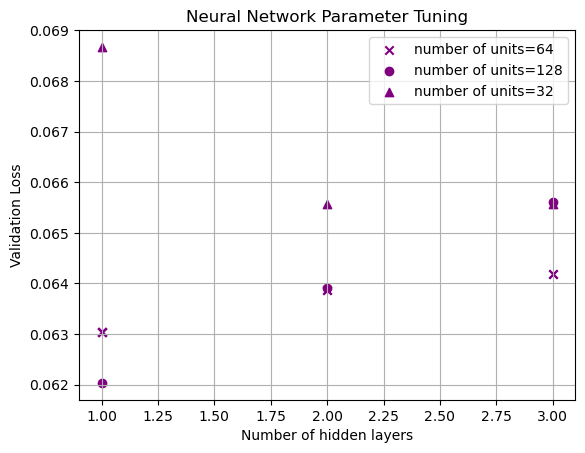

In [14]:
markers_dict = {64: 'x', 128: 'o', 32: '^'}
plt.xlabel('Number of hidden layers')
plt.ylabel('Validation Loss')
plt.title('Neural Network Parameter Tuning')

# Set to keep track of unique labels
unique_labels = set()

for i, config in enumerate(config_models):
    label = f'number of units={config[1]}'
    
    # Only add to the legend if the label hasn't been added before
    if label not in unique_labels:
        plt.scatter(config[0], val_min_hypertune[config], marker=markers_dict[config[1]], label=label, color='purple')
        unique_labels.add(label)
    else:
        
        plt.scatter(config[0], val_min_hypertune[config], marker=markers_dict[config[1]], color='purple')

plt.grid()
plt.legend()
plt.show()


13650/13650 [==============================] - 15s 1ms/step


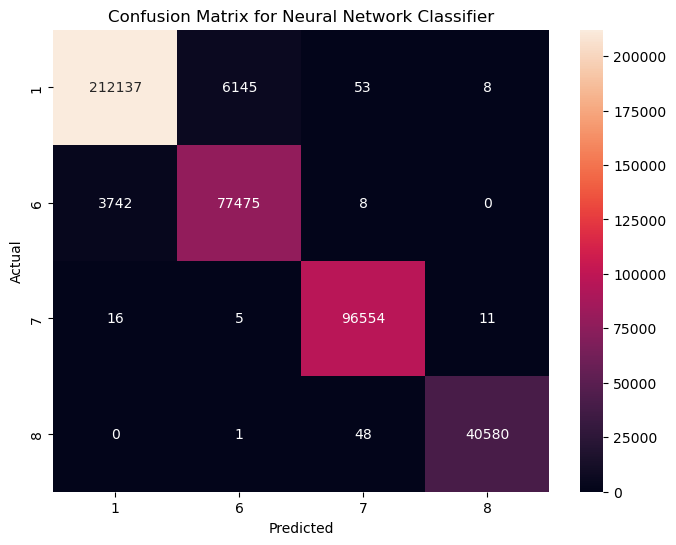

              precision    recall  f1-score   support

           1   0.971577  0.982593  0.977054    215895
           6   0.953832  0.926446  0.939940     83626
           7   0.999669  0.998872  0.999270     96663
           8   0.998794  0.999532  0.999163     40599

    accuracy                       0.977021    436783
   macro avg   0.980968  0.976861  0.978857    436783
weighted avg   0.976926  0.977021  0.976920    436783



In [15]:

# cambia con minimo di validation loss
model_RNN_4.load_weights('RNN_eng4.ckpt')

predictions = model_RNN_4.predict(X_test)

# Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d",  xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


preds_prob = np.argmax(predictions, axis = 1)
label_reverse = {0: 1, 1: 6, 2: 7, 3: 8}
preds = []
for pred in preds_prob:
    preds.append(label_reverse[pred])

actual = []
y_test_prob = np.argmax(y_test_one_hot, axis = 1)
for test in y_test_prob:
    actual.append(label_reverse[test])


# Plot the confusion matrix for the training set
plot_confusion_matrix(preds, actual, "Confusion Matrix for Neural Network Classifier")
from sklearn.metrics import classification_report
sk_report = classification_report(
    digits=6,
    y_true=actual, 
    y_pred=preds)
print(sk_report)

# Save the predictions
with open('predictions_RNN_eng.pkl', 'wb') as file:
    data_to_store = predictions
    pickle.dump(data_to_store, file)

In [19]:
# Save the predictions
with open('losses_eng.pkl', 'wb') as file:
    data_to_store = (train_loss, val_loss) 
    pickle.dump(data_to_store, file)

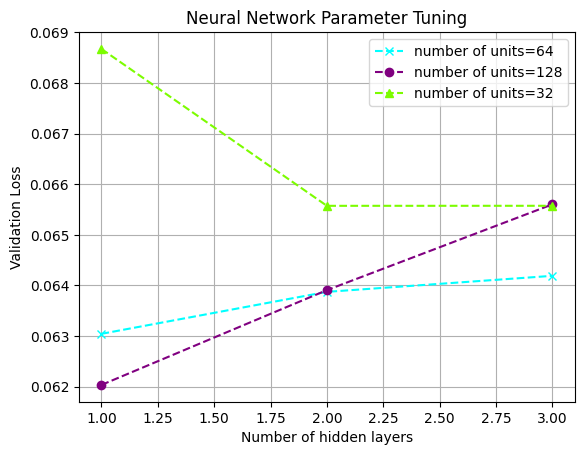

In [10]:
dict_values = {64: [0.06304267048835754,  0.0638723224401474, 0.06418899446725845], 128:[0.062033068388700485, 0.06390652805566788,  0.06560096889734268], 32: [0.06867332011461258,  0.06557250767946243,  0.06557328999042511]}
markers_dict = {64: 'x', 128: 'o', 32: '^'}
color_dict = {64:'cyan', 128:'purple', 32:'lawngreen'}
plt.xlabel('Number of hidden layers')
plt.ylabel('Validation Loss')
plt.title('Neural Network Parameter Tuning')

# Set to keep track of unique labels
unique_labels = set()

for i, unit in enumerate([64,128,32]):
    label = f'number of units={unit}'
   
    plt.plot(range(1,4), dict_values[unit], marker=markers_dict[unit], label=label, color=color_dict[unit], linestyle='dashed')
           

plt.grid()
plt.legend()
plt.show()
